In [30]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# from test_utils import summary, comparator
# import public_tests

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

In [31]:
# pip install public_tests
# !pip install comparator
# !pip install test-utils
# !pip install summary

Table of Content

---

 1 - Packages

---


2 - The Problem of Very Deep Neural Networks

---


3 - Building a Residual Network

---


3.1 - The Identity Block

---


Exercise 1 - identity_block

---


3.2 - The Convolutional Block

---


Exercise 2 - convolutional_block

---


4 - Building Your First ResNet Model (50 layers)

1.   List item
2.   List item


Exercise 3 - ResNet50
5 - Test on Your Own Image (Optional/Ungraded)
6 - Bibliography

In [32]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()

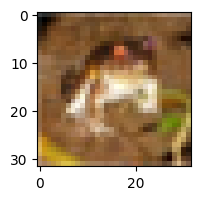

In [35]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[0])

In [36]:

 (X_train.shape),(y_train.shape)

((50000, 32, 32, 3), (50000, 1))

In [37]:
X_train = X_train / 255
X_test = X_test / 255

In [38]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X,training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X,training = training)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [39]:
### you cannot  edit this call :

np.random.seed(1)
tf.random.set_seed(2)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
tf.random.set_seed(2)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))



With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71234 192.71234 192.71234  96.85617]
  [ 96.85617  96.85617  96.85617  48.92808]]

 [[578.1371  578.1371  578.1371  290.5685 ]
  [290.5685  290.5685  290.5685  146.78426]]]
96.85617

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]


In [40]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size =(1,1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2,kernel_size = (f,f),strides=(1,1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3,)(X,training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X,training=training)

    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut,training=training)

    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [41]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    #define  the input as tensor  with shape input_shape
    X_input = Input(input_shape)

    #zero-padding:
    X = ZeroPadding2D((3,3))(X_input)

    #layer-1
    X =  Conv2D(64,(7,7),strides = (2,2),kernel_initializer = glorot_uniform(seed=0))(X)
    X =  BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)

    # layers-2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    # layers- 3
    X = convolutional_block(X,f=3,filters=[128,128,512],s=2)

    X = identity_block(X,3,[128,128,512])
    X = identity_block(X,3,[128,128,512])
    X = identity_block(X,3,[128,128,512])


    #layers - 4
    # adding f "filters" ,  s " Stage"
    X = convolutional_block(X,f=3,filters=[256,256,1024],s=2)

    #laywrs -5
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])

    # adding f "filters" ,  s " Stage"
    X = convolutional_block(X,f=3,filters=[512,512,2048],s=2)



    # layers-5
    X = convolutional_block(X,f=3,filters=[512,512,2048],s=2)

    X = identity_block(X,3,[512,512,2048])
    X = identity_block(X,3,[512,512,2048])


    X = AveragePooling2D(pool_size=(2,2),padding='same')(X)


# OUTPUT Layers

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

# Create Model:
    model = Model(inputs = X_input, outputs = X)

    return model


In [42]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 38, 38, 3)            0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_126 (Conv2D)         (None, 16, 16, 64)           9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 batch_normalization_126 (B  (None, 16, 16, 64)           256       ['conv2d_126[0][0]']    

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
y_train = y_train.astype("int")

In [45]:
from keras.src.utils.np_utils import to_categorical
# X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train / 255.
X_test = X_test / 255.

from keras.utils import to_categorical

# y_train = to_categorical(y_train,10)
# y_test = to_categorical(y_test,10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 1)


In [47]:
X_train.shape

(50000, 32, 32, 3)

In [48]:
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10


ValueError: ignored